In [1]:
import keras
keras.__version__

Using TensorFlow backend.


'2.3.1'

In [2]:
from keras.applications import VGG16

conv_base = VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=(150, 150, 3))


# input_shape : the shape of the image tensors that we will feed to the network. 
# This argument is purely optional: if we don't pass it, then the network will be able to process inputs of any size.

In [3]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0     

## Approach1: Running Conv2D once on every image and then feeding to the dense layer
 **This technique is cheap but data augumentation is not sutiable in this approach**

In [4]:
# features = np.zeros(shape=(sample_count, 4, 4, 512))
# here for conv_base we have defined the input shape our model takes, then it performs convolution on the datagenerator we 
# created and finally gives output od shape= (4, 4, 512). 
# So, to store it to further feed the dense layer we need to craete a array i.e. features which stores the conv2D output
# for the images in our dir. 
# Thus features = np.zeros(shape=(image_in_dir, conv2d_output))

In [5]:
import os
import numpy as np
from keras.preprocessing.image import ImageDataGenerator

base_dir = r"C:\Users\rakes\Desktop\Rakesh\Deep Learning\Deep Learning with Python - Francois Chollet\Ch-5\cats_dogs_small"
train_dir = os.path.join(base_dir, 'train_dir')
validation_dir = os.path.join(base_dir, 'validation_dir')
test_dir = os.path.join(base_dir, 'test_dir')

datagen = ImageDataGenerator(rescale=1./255)
batch_size = 20

# sample_count: no. of samples in the directory
def extract_features(directory, sample_count):
    features = np.zeros(shape=(sample_count, 4, 4, 512))
    labels = np.zeros(shape=(sample_count))
    generator = datagen.flow_from_directory( directory, target_size=(150, 150), batch_size=batch_size,
                                            class_mode='binary')
    
    i = 0
    for inputs_batch, labels_batch in generator:
        features_batch = conv_base.predict(inputs_batch)
        features[i * batch_size : (i + 1) * batch_size] = features_batch
        labels[i * batch_size : (i + 1) * batch_size] = labels_batch
        i += 1
#         print(features_batch.shape)
        if i * batch_size >= sample_count:
            break                                                           
    return features, labels

train_features, train_labels = extract_features(train_dir, 2000)
validation_features, validation_labels = extract_features(validation_dir, 1000)
test_features, test_labels = extract_features(test_dir, 1000)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [6]:
# Flattening the tensor output from the conv2D layer: the conv2D layer output is (4, 4, 512) so flattening to 4*4*512

train_features = np.reshape((train_features), (2000, 4*4*512))
validation_features = np.reshape((validation_features), (1000, 4*4*512))
test_features = np.reshape((test_features), (1000, 4*4*512))

In [7]:
from keras import models
from keras import optimizers
from keras import losses
from keras.layers import Dense, Dropout

model = models.Sequential()
model.add(Dense(256, activation='relu', input_dim=4*4*512))
model.add(Dropout(0.5))
model.add(Dense(1,activation='sigmoid'))

model.compile(optimizer= optimizers.RMSprop(lr=2e-5), loss=losses.binary_crossentropy, metrics=['acc'])

In [8]:
history = model.fit(train_features, train_labels,
                    batch_size=20, epochs=30,
                    validation_data=(validation_features, validation_labels))

Train on 2000 samples, validate on 1000 samples
Epoch 1/30
2000/2000 [==============================] - 3s 2ms/step - loss: 0.6158 - acc: 0.6595 - val_loss: 0.4427 - val_acc: 0.8370
Epoch 2/30
2000/2000 [==============================] - 3s 2ms/step - loss: 0.4247 - acc: 0.8200 - val_loss: 0.3755 - val_acc: 0.8620
Epoch 3/30
2000/2000 [==============================] - 3s 2ms/step - loss: 0.3629 - acc: 0.8440 - val_loss: 0.3227 - val_acc: 0.8810
Epoch 4/30
2000/2000 [==============================] - 3s 2ms/step - loss: 0.3152 - acc: 0.8705 - val_loss: 0.2972 - val_acc: 0.8840
Epoch 5/30
2000/2000 [==============================] - 3s 2ms/step - loss: 0.2862 - acc: 0.8890 - val_loss: 0.2852 - val_acc: 0.8920
Epoch 6/30
2000/2000 [==============================] - 3s 2ms/step - loss: 0.2704 - acc: 0.8915 - val_loss: 0.2804 - val_acc: 0.8890
Epoch 7/30
2000/2000 [==============================] - 4s 2ms/step - loss: 0.2463 - acc: 0.9060 - val_loss: 0.2625 - val_acc: 0.8950
Epoch 8/30
200

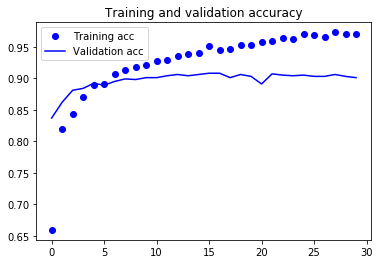

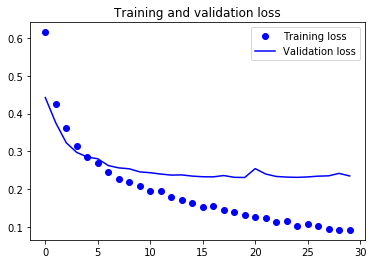

In [9]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [10]:
model.save('dog_and_cat_classifier_VGG16.h5')